# Spectral FPM Simulation and Reconstruction Code

Neerja Aggarwal

Sep 20th, 2023

Now let's have our object be spectrally constant.  For this, first let's assume that we have a resolution target that has the same spectrum across pixels.  And let's insert a filter in the fourier plane.  3x3 where each cell lets through one of the wavelength channels. 

## Import and Setup

In [1]:
# load relevant libraries
# activate pytorch conda environment on fuoco

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import math
import os

from IPython import display # for refreshing plotting


In [2]:
# set up to use the gpu
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
use_gpu = True
gpu = 0
if use_gpu:
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    torch.cuda.set_device(gpu)
    device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device('cpu') # uncomment this line to use cpu
torch.cuda.empty_cache()  #empty any variables in cache to free up space
print(device)



cuda:0


In [3]:
t = torch.cuda.get_device_properties(gpu).total_memory
print(t)

12781879296


CHANGE experiment parameters here:

In [4]:
# set the following parameters
mag = 4 # 4x 
na_obj = 0.1 # low na objective 
pix_size_camera = 4 #  micron"

wv_start = 400e-3 # micron
wv_end = 800e-3 # micron
wv_step = 50e-3 # micron

# these are computed automatically
wv_range = np.arange(wv_start,wv_end, wv_step) # spectral channel center vector
Nw = len(wv_range)
pix_size_object =pix_size_camera/mag # micron  

# Create helper functions

In [5]:
# start with an image in the object plane
# let's load a high resolution res target and just upsample for now?  we'll just do a mini version with limited angles. 
path = '../../DATA/SpectralFPMData/usafrestarget.jpeg'
im = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel


def preprocessObject(im):
    (Ny,Nx) = im.shape
    # make image square
    if Ny<Nx:
        im = im[:,1:Ny]
    elif Nx<Ny:
            im = im[1:Nx,:]
    # make even dimensions
    if Ny % 2 != 0:
        im = im[:-1,:]
    if Nx % 2 != 0:
        im = im[:,:-1]
    return im
def makeSpectralObject(im,spectrum):
    obj = torch.unsqueeze(im,0)
    obj = obj*spectrum
    return obj

im = preprocessObject(im)
(Ny,Nx) = im.shape
Npixel = Ny


/home/neerja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  after removing the cwd from sys.path.


In [6]:
# make into spectral object
spectrum = torch.ones([Nw,1,1])  # create a spectrum vector with dimension (Nw, 1,1)
spectral_im = im.unsqueeze(0)*spectrum  # elementwise multiply with the sample after expanding dim0 to be wavelength

torch.Size([8, 1178, 1178])


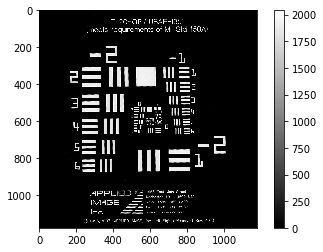

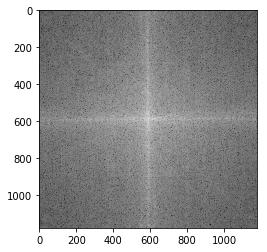

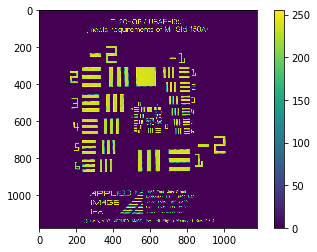

In [7]:
# look at image
sim_xy = torch.sum(spectral_im, dim=0)
plt.imshow(sim_xy,'gray')
plt.colorbar()


pup_obj = torch.fft.fftshift(torch.fft.fft2(sim_xy))
plt.figure()
plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')


# look at single channel
plt.figure()
sim_0 = spectral_im[3,:,:]
plt.imshow(sim_0)
plt.colorbar()
print(spectral_im.shape)

Text(0.5, 1.0, 'wv = 750nm')

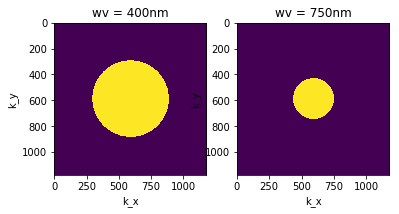

In [8]:
# make pupil mask
def createPupilStop(na_obj, wv, pix_size_object, Npixel):
    fPupilEdge = na_obj/wv # edge of pupipl is NA/wavelength
    fMax = 1/(2*pix_size_object)
    df = 1/(Ny*pix_size_object) # assume square image
    fvec = np.arange(-fMax,fMax,df)
    fxc,fyc = np.meshgrid(fvec,fvec)
    # caclulate radius of f coordinates
    frc = np.sqrt(fxc**2+fyc**2)
    pupil = np.zeros_like(frc) 
    pupil[frc<fPupilEdge] = 1 # make everything inside fPupilEdge transmit 100%
    return torch.Tensor(pupil)

pupilstack = torch.zeros([Nw,Ny,Nx])
for k in np.arange(Nw):
    wv = wv_range[k]
    pupilstack[k,:,:]  = createPupilStop(na_obj,wv,pix_size_object, Npixel)

k =0
plt.subplot(1,2,1)
plt.imshow(pupilstack[k,:,:])
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")

k=-1
plt.subplot(1,2,2)
plt.imshow(pupilstack[k,:,:])
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")

tile:  [[1 2 3]
 [4 5 6]
 [7 8 1]]
ind:  1
wv:  0.4
f_width:  0.3535533905932738
f_width_ind:  416
mul_factor:  138
(414, 414)
[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]]
aperture:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
aperture.shape:  torch.Size([1178, 1178])
tensor(704628.)
tensor(704628.)
tile:  [[1 2 3]
 [4 5 6]
 [7 8 1]]
ind:  2
wv:  0.45
f_width:  0.3142696805273545
f_width_ind:  370
mul_factor:  123
(369, 369)
[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]]
aperture:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  

Text(0.5, 1.0, 'wv = 750nm')

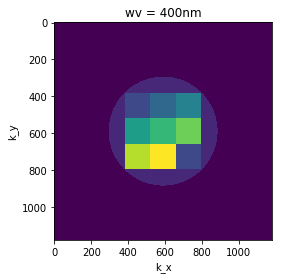

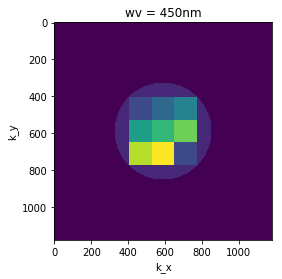

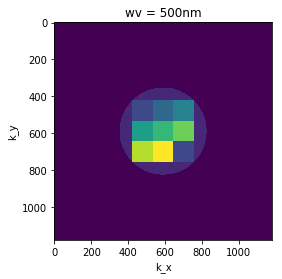

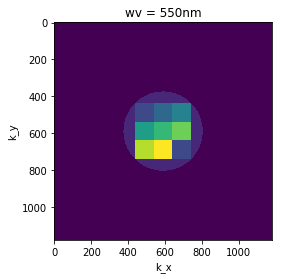

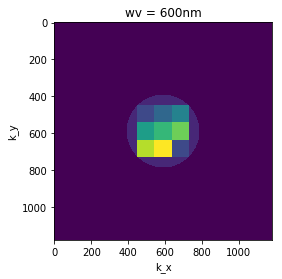

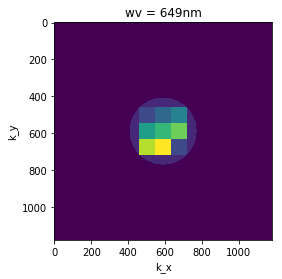

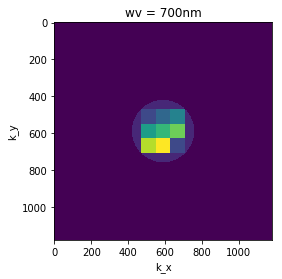

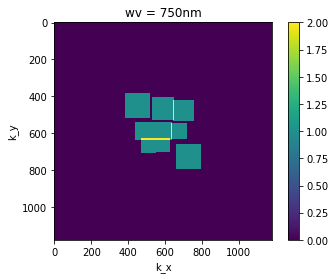

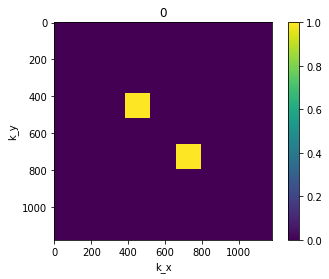

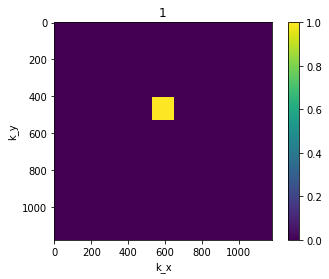

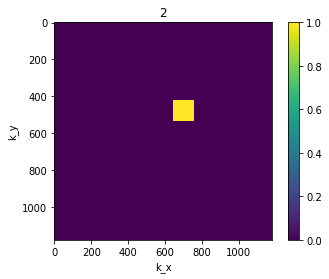

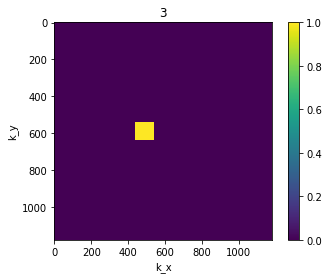

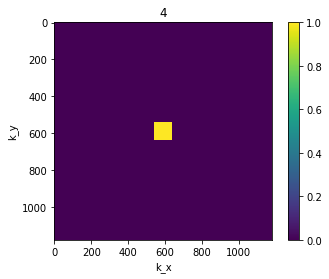

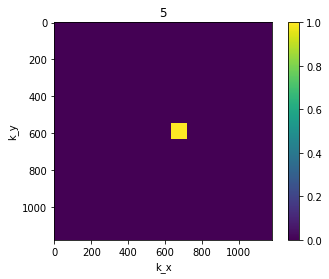

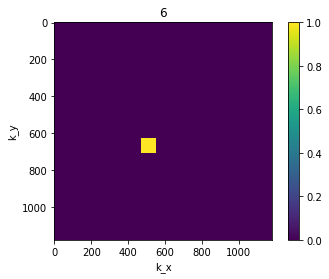

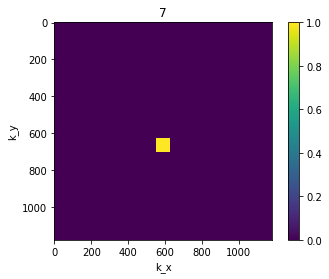

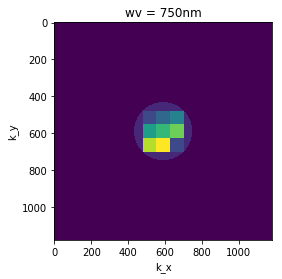

In [9]:
# make aperture
# let's say our apperture is defined in physical xy space?  Then it needs to be converted into kx, ky space for each wavelength. 

def createTile(Nw):
    a = np.arange(1,Nw+1) # get vector from 0 to Nw-1
    s = np.ceil(np.sqrt(Nw)).astype(int) # compute sqrt of number of channels and round up to the next integer.  Ex: sqrt(8)--> 3x3 matrix
    a = np.resize(a, (s,s))
    return(a)

def createApertureFromTile(a,na_obj,ind, wv, pix_size_object, Ny,Nx):
    print('tile: ',a)
    print('ind: ',ind)
    print('wv: ', wv)
    df = 1/(Ny*pix_size_object) 
    f_width = na_obj/wv*np.sqrt(2) # side of largest square that can fit in circle pupil 
    print('f_width: ',f_width)
    f_width_ind = np.floor(f_width/df).astype(int)
    print('f_width_ind: ',f_width_ind)
    mul_factor = int(f_width_ind/a.shape[0]) # assume you want square apperture
    print('mul_factor: ',mul_factor)
    aperture = np.repeat(np.repeat(a, mul_factor, axis = 0), mul_factor, axis = 1) # stretch the filter array
    print(aperture.shape)
    print(aperture)
    
    # pad into appropriate size
    pady = int((Ny-f_width_ind)/2)+1
    padx = int((Nx-f_width_ind)/2)+1
    aperture = np.pad(aperture, ((pady, pady),(padx,padx)),mode='constant')
    aperture = aperture[0:Ny,0:Nx] # correct size
    if aperture.shape[0] != Ny or aperture.shape[1] != Nx:
        print('aperture matrix size incorrect!') # catch remaining error

    # pick out into channels
    frame = np.zeros((Ny,Nx))
    frame[np.where(aperture == ind)] = 1
    return (torch.Tensor(frame), torch.Tensor(aperture))


aperture_stack = torch.zeros([Nw,Ny,Nx])
tile = createTile(Nw) # motif for filter array. 
for k in np.arange(Nw):
    wv = wv_range[k]
    (aperture_stack[k,:,:], aperture) = createApertureFromTile(tile,na_obj,k+1, wv, pix_size_object, Ny,Nx)
    
    print('aperture: ',aperture)
    print('aperture.shape: ',aperture.shape)
    print(torch.sum(torch.sum(aperture,axis=0)))
    print(torch.sum(torch.sum(aperture,axis=1)))    
    plt.figure()
    plt.imshow(pupilstack[k,:,:]+aperture)
    #plt.imshow(aperture)
    plt.xlabel('k_x')
    plt.ylabel('k_y')
    plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")

print(aperture_stack.shape)
plt.imshow(torch.sum(aperture_stack,axis = 0))
plt.colorbar()
plt.xlabel("k_x")
plt.ylabel('k_y')

for wv_ind in np.arange(8):
    plt.figure()
    plt.imshow(aperture_stack[wv_ind,:,:])
    plt.colorbar()
    plt.xlabel("k_x")
    plt.ylabel('k_y')
    plt.title(wv_ind)

k=-1
plt.figure()
plt.imshow(pupilstack[k,:,:]+aperture)
#plt.imshow(aperture)
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")


Text(0, 0.5, 'Y')

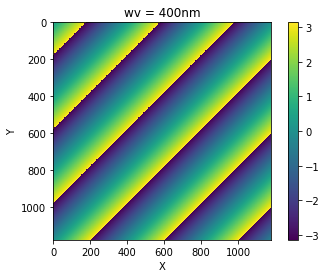

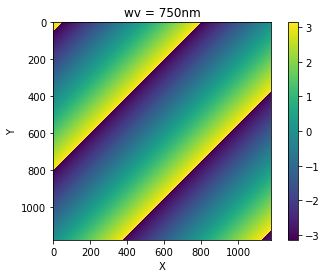

In [10]:
# create xy grid for object space (used for illumination field)
def createXYgrid(pix_size_object,Nx,Ny):
    xvec = np.arange(-pix_size_object*Nx/2,pix_size_object*Nx/2,pix_size_object)
    yvec = np.arange(-pix_size_object*Ny/2,pix_size_object*Ny/2,pix_size_object)
    xygrid = torch.Tensor(np.array(np.meshgrid(xvec,yvec)))
    return xygrid

# create the illumination field given angle of planewave
def createIllumField(xygrid, illum_angle, wv):
    rady = illum_angle[0]
    radx = illum_angle[1]
    k0 = 2*math.pi/wv
    ky = k0*math.sin(rady)
    kx = k0*math.sin(radx)
    field = torch.exp(1j*kx*xygrid[1] + 1j*ky*xygrid[0])
    return field

# look at an example illumination field
illum_angle = (.001,.001)  # y,x  # unit is in radians
xygrid = createXYgrid(pix_size_object,Nx,Ny)


# create stack of illum field
illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64)  # use complex dtype
for k in np.arange(Nw):
    wv = wv_range[k]
    illumstack[k,:,:] = createIllumField(xygrid,illum_angle,wv)

k=0
field = illumstack[k,:,:]
plt.figure()
plt.imshow(torch.angle(field))
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

k=-1
field = illumstack[k,:,:]
plt.figure()
plt.imshow(torch.angle(field))
plt.title('wv = ' + str(int(wv_range[k]*1000)) + "nm")
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')



<Figure size 432x288 with 0 Axes>

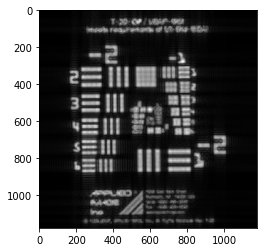

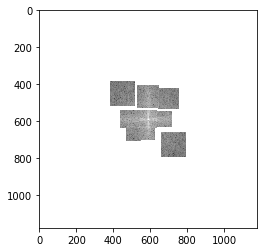

<Figure size 432x288 with 0 Axes>

In [11]:
# compute the measurement given an object and incident wave field and pupil stop
def forwardSFPM(objstack, pupilstack, illumstack, Nw):
    # multiply by the sample
    for k in torch.arange(Nw):
        obj = objstack[k]
        pupil = pupilstack[k]
        field = illumstack[k]
        obj_field = field*obj
        # take the fourier transform and center in pupil plane
        pup_obj = torch.fft.fftshift(torch.fft.fft2(obj_field))*pupil
        # multiply object's FFT with the pupil stop and take ifft to get measurement
        if k==0:
            y = torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
            pup_out = pup_obj 
        else:
            y = y+torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
            pup_out = pup_out + pup_obj 
        # subsample according to pixel size on camera?
    return (y, pup_out)

# look at an example measurement
(y, pup_obj) = forwardSFPM(spectral_im,aperture_stack, illumstack, Nw)
plt.imshow(torch.abs(y),'gray')
plt.figure()
plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')
plt.figure()


## Simulate lots of forward measurements


In [12]:
# create list of illumination angles (leds) to turn on one at a time
def createlist_led(num_leds,minval,maxval):
    list_leds = np.random.uniform(low = minval, high = maxval, size = (num_leds,2))
    # append a (0,0) bf led
    list_leds = np.append(list_leds,np.zeros([1,2]), axis = 0 )
    return list_leds

tile:  [[1 2 3]
 [4 5 6]
 [7 8 1]]
ind:  1
wv:  0.4
f_width:  0.3535533905932738
f_width_ind:  416
mul_factor:  138
(414, 414)
[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]]
tile:  [[1 2 3]
 [4 5 6]
 [7 8 1]]
ind:  2
wv:  0.45
f_width:  0.3142696805273545
f_width_ind:  370
mul_factor:  123
(369, 369)
[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]]
tile:  [[1 2 3]
 [4 5 6]
 [7 8 1]]
ind:  3
wv:  0.5
f_width:  0.28284271247461906
f_width_ind:  333
mul_factor:  111
(333, 333)
[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]]
tile:  [[1 2 3]
 [4 5 6]
 [7 8 1]]
ind:  4
wv:  0.55
f_width:  0.25712973861329
f_width_ind:  302
mul_factor:  100
(300, 300)
[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]]
tile:  [[1 

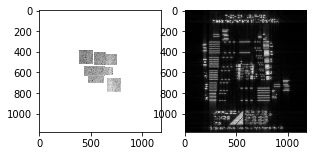

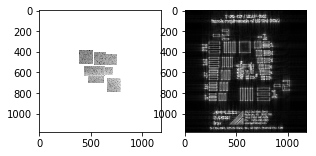

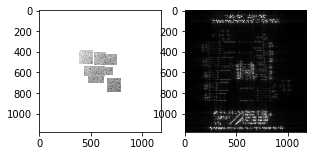

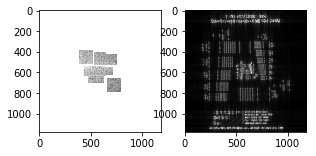

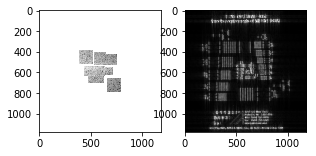

In [13]:
d = 75 # distance away led to object
# let's go up to 15 mm out (15/5 = 3)
led_spacing = 5 # roughly 5 mm apart LEDs
#
list_leds = createlist_led(100,-3,3) 
num_meas = len(list_leds) 
# load data
path = '../../DATA/SpectralFPMData/usafrestarget.jpeg'
obj = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel
obj = preprocessObject(obj) # make it square and even
(Ny,Nx) = obj.shape
Npixel = Ny

# create grid
xygrid = createXYgrid(pix_size_object,Nx,Ny)

# # do not need to create pupil since we are using the aperture
# pupilstack = torch.zeros([Nw,Ny,Nx])
# for k1 in np.arange(Nw):
#     wv = wv_range[k1]
#     pupilstack[k1,:,:]  = createPupilStop(na_obj,wv,pix_size_object, Npixel)

# create aperture stacks
aperture_stack = torch.zeros([Nw,Ny,Nx])
tile = createTile(Nw) # motif for filter array. 
for k in np.arange(Nw):
    wv = wv_range[k]
    (aperture_stack[k,:,:], aperture) = createApertureFromTile(tile,na_obj,k+1, wv, pix_size_object, Ny,Nx)

# create measurement stack
measstack = torch.zeros(num_meas,Ny,Nx)

#start iterating through LEDs
for k2 in np.arange(num_meas):
    # take led indices and calculate angle of incidence
    led_ind = list_leds[k2]  
    led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (x,y,z)
    illum_angle = (np.arctan(led_pos[1]/led_pos[2]), np.arctan(led_pos[0]/led_pos[2]))
    # print(illum_angle)
    # create illumination field stack 
    illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64)  # use complex dtype
    for k1 in np.arange(Nw):
        wv = wv_range[k]
        illumstack[k1,:,:] = createIllumField(xygrid,illum_angle,wv)
        
    # simulate the forward measurement
    (y, pup_obj) = forwardSFPM(spectral_im,aperture_stack, illumstack, Nw)
    # print(k2)
    # plot some example measurements
    if k2<5:
        plt.figure(figsize=(10,10))
        plt.subplot(1,4,1)
        plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')
        plt.subplot(1,4,2)
        plt.imshow(torch.abs(y),'gray')
    measstack[k2,:,:] = y


In [14]:
def computesize(a):
    return(a.element_size() * a.nelement() /1e9)

print(computesize(measstack))
print(computesize(spectral_im))
print(computesize(aperture_stack))

0.560624336
0.044405888
0.044405888


## Reconstruction

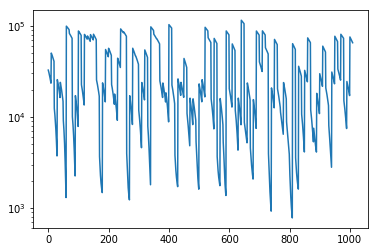

In [15]:
# obj_est = torch.zeros_like(obj,dtype = torch.float) # initializing to zeros doesn't work well. 
# obj_est = measstack[0,:,:] # initialize to first measurement instead
init_spectrum = torch.ones([Nw,1,1])  # create a spectrum vector with dimension (Nw, 1,1)
obj_est = measstack[0,:,:].unsqueeze(0).to(device)*init_spectrum.to(device)
obj_est.requires_grad = True
# regularizers
def hardthresh(x,val):
    return torch.maximum(x,torch.tensor(val))

# set hyperparameters
step_size = 3e2
num_iters = 10
num_epochs = 1
num_meas = len(list_leds)
losses =[]
# move to gpu
if use_gpu == 1:
    with torch.no_grad():
        obj_est = obj_est.to(device)
        aperture_stack = aperture_stack.to(device)
        measstack = measstack.to(device)
        obj_est.requires_grad = True

"""
# loop through iterations 
# loop through measurement
for k2 in np.arange(num_meas):
    print('Measurement: ',k2)
    # loop through iteration
    for k1 in np.arange(num_iters): 
    
    # loop through iterations        
for k1 in np.arange(num_iters):
    print('Iteration: ',k1)
    # loop through measurement
    for k2 in np.arange(num_meas): 
"""

"""
#What Neerja told me to do


#Epoch for loop here:
for k0 in np.arange(num_epochs):
    # loop through measurement
    for k2 in np.arange(num_meas):
        print('Measurement: ',k2)
        # loop through iteration
        for k1 in np.arange(num_iters):
        #try switching k1 and k2?
"""        
        
"""            
#Original configuration: for each measurement, loop through the iterations           
for k2 in np.arange(num_meas): 
    # loop through iterations
    for k1 in np.arange(num_iters):   
"""
#Epoch for loop here:
for k0 in np.arange(num_epochs):
    print("EPOCH: ",k0)
    # loop through measurements
    for k2 in np.arange(num_meas):
        # loop through iteration
        for k1 in np.arange(num_iters):    
            # get relevant actual measurement and move to gpu
            meas = measstack[k2,:,:]
            # loop through wavelength 
            # compute illumination angle from led indices
            led_ind = list_leds[k2]   
            led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (x,y,z)
            illum_angle = (np.arctan(led_pos[1]/led_pos[2]), np.arctan(led_pos[0]/led_pos[2]))

            # create stack of illum field
            illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64).to(device)  # use complex dtype
            for k3 in np.arange(Nw):
                wv = wv_range[k3]
                illumstack[k3,:,:] = createIllumField(xygrid,illum_angle,wv)

            # simulate the forward measurement
            #Same as creating measurement stack except object_estimate instead of spectral_im is first argument
            
            #Initially, obj_est = measstack[0,:,:]...
            #Initializing to the first measurement! But then iterating through all measurements
            #measstack is created by iterating through the measurements and then doing the forward measurement for each measurement... list_leds???
            #forward_measurement = pupil * X
            #Isn't obj_est going through the forward measurement 2x? And many many times?
            (yest, pup_obj) = forwardSFPM(obj_est,aperture_stack, illumstack, Nw)

            # calculate error, aka loss, and backpropagate
            error = torch.norm(yest-meas)
            #.detach(): returns a new tensor detached from the current graph
            #.cpu(): returns a copy of this object in CPU memory
            losses += [error.detach().cpu()]
            #Compute gradient of tensor wrt graph leaves
            error.backward()
            # print(error)

            # update the object's reconstruction estimate based on error
            with torch.no_grad(): # need to do inplace operations inside this no_grad() function to retain as leaf variables. 
                # print(torch.norm(obj_est.grad))
                obj_est = obj_est - step_size*obj_est.grad # gradient update
                obj_est = hardthresh(obj_est,0) # proximal update

            # ensure the obj_est's grad flag is set correctly for next iteration to run properly
            obj_est.requires_grad = True

            #if k2 == num_meas-1:
            if k1 == num_iters-1:
                    try:
                        print('Epoch: %s Iteration: %s Measurement: %s' % (k0,k1,k2))
                        plt.clf() # clear plot
                        plt.semilogy(losses)
                        display.display(plt.gcf()) # update single window
                        display.clear_output(wait=True) # update single window
                        # time.sleep(1)
                    except KeyboardInterrupt:
                        break

In [16]:
print(len(losses))
print(num_meas)
print(losses)

1010
101
[tensor(32680.7148), tensor(31820.6816), tensor(30835.0430), tensor(29812.2012), tensor(28771.6602), tensor(27721.2715), tensor(26665.1348), tensor(25605.7949), tensor(24545.0332), tensor(23484.2285), tensor(50268.5312), tensor(49343.8906), tensor(48325.5469), tensor(47277.7031), tensor(46214.7266), tensor(45142.4766), tensor(44064.1133), tensor(42981.6680), tensor(41896.5391), tensor(40809.7852), tensor(12427.3564), tensor(11495.5938), tensor(10493.3994), tensor(9474.2822), tensor(8454.1025), tensor(7442.6060), tensor(6449.2153), tensor(5485.8564), tensor(4569.8892), tensor(3728.1597), tensor(25692.2520), tensor(24765.9824), tensor(23747.5898), tensor(22704.3594), tensor(21649.4863), tensor(20588.5371), tensor(19524.7109), tensor(18460.2793), tensor(17396.9531), tensor(16336.2686), tensor(23966.3613), tensor(22958.6348), tensor(21941.2148), tensor(20919.1211), tensor(19895.4219), tensor(18872.6113), tensor(17852.6465), tensor(16837.4023), tensor(15828.7754), tensor(14828.5371

NameError: name 'obj_est_norm' is not defined

<Figure size 432x288 with 0 Axes>

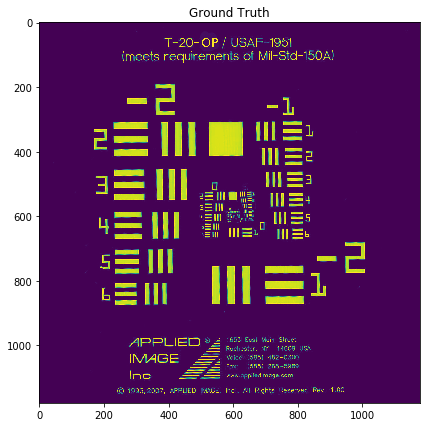

In [17]:
plt.clf()

plt.figure(figsize = (15,10))
plt.subplot(1,2,1)
spectral_im[0,:,:] = spectral_im[0,:,:]/torch.amax(spectral_im[0,:,:])
plt.imshow(spectral_im[0,:,:].detach().cpu().numpy())
plt.title('Ground Truth')
print(torch.norm(obj_est_norm))
plt.colorbar(shrink=0.5) 

plt.subplot(1,2,2)
obj_est_norm = torch.sum(obj_est,dim=0)
obj_est_norm = obj_est_norm/torch.amax(obj_est_norm)
plt.imshow(obj_est_norm.detach().cpu().numpy())
plt.title('Object Estimate XY Projection')
print(torch.norm(obj_est_norm))
plt.colorbar(shrink=0.5) 

tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)


Text(0.5, 1.0, 'Brightfield Measurement')

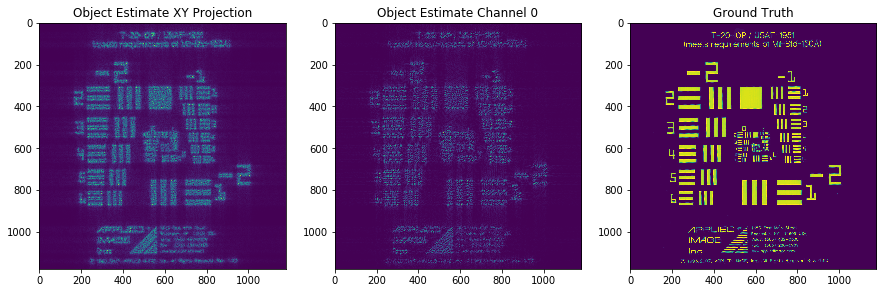

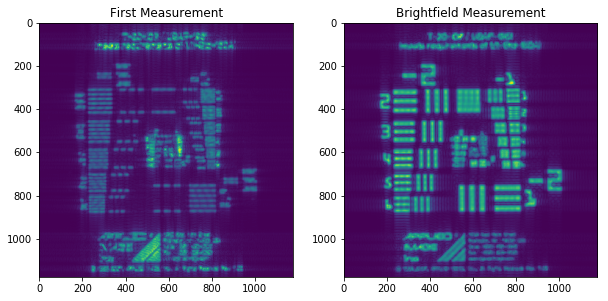

In [18]:
#plt.style.use('dark_background')

num_plots = 3

plt.figure(figsize = (15,10))
plt.subplot(1,num_plots,1)
obj_est_norm = torch.sum(obj_est,dim=0)
obj_est_norm = obj_est_norm/torch.amax(obj_est_norm)
plt.imshow(obj_est_norm.detach().cpu().numpy())
plt.title('Object Estimate XY Projection')
print(torch.norm(obj_est_norm))
# plt.colorbar()
# plt.clim([0,.9])

plt.subplot(1,num_plots,2)
obj_est0 = obj_est[0,:,:]/torch.amax(obj_est[0,:,:])
plt.imshow(obj_est0.detach().cpu().numpy())
plt.title('Object Estimate Channel 0')
print(torch.norm(obj_est_norm))
# plt.colorbar()
# plt.clim([0,.9])

"""
plt.subplot(1,num_plots,3)
obj_est1 = obj_est[1,:,:]/torch.amax(obj_est[1,:,:])
plt.imshow(obj_est1.detach().cpu().numpy())
plt.title('Object Estimate Channel 1')
print(torch.norm(obj_est_norm))
# plt.colorbar()
# plt.clim([0,.9])
"""
plt.subplot(1,num_plots,3)
spectral_im[0,:,:] = spectral_im[0,:,:]/torch.amax(spectral_im[0,:,:])
plt.imshow(spectral_im[0,:,:].detach().cpu().numpy())
plt.title('Ground Truth')
print(torch.norm(obj_est_norm))
# plt.colorbar()
# plt.clim([0,.9])


plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.imshow(measstack[0,:,:].detach().cpu())
plt.title('First Measurement')
# plt.colorbar()
# plt.clim([0,.3])

plt.subplot(1,2,2)
plt.imshow(measstack[-1,:,:].detach().cpu())
plt.title('Brightfield Measurement')
# plt.colorbar()
# plt.clim([0,.3])

tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(160.7405, device='cuda:0', grad_fn=<CopyBackwards>)


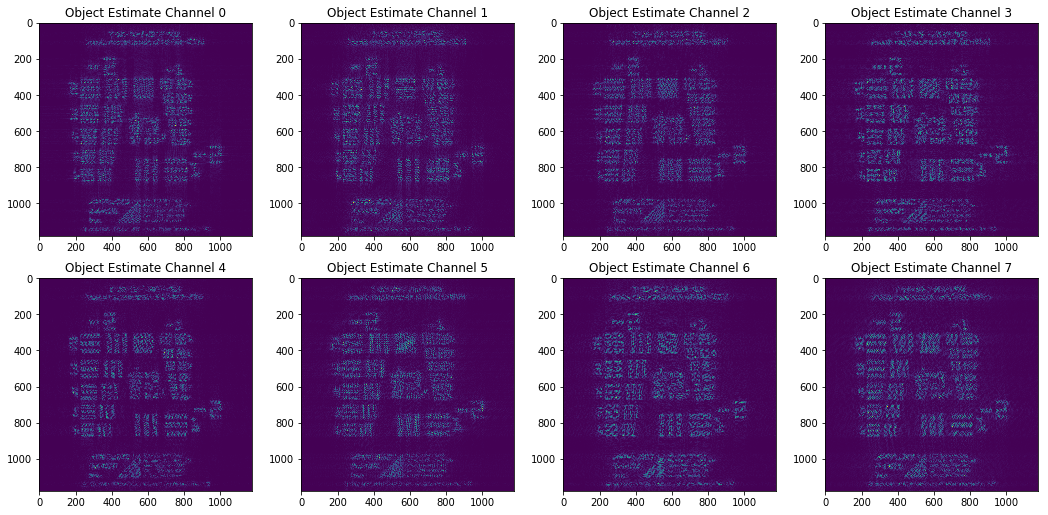

In [19]:
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(18)  
for plot_ind in np.arange(1,9):  
    plt.subplot(4,4,plot_ind)
    plot_ind = plot_ind - 1
    obj_est1 = obj_est[plot_ind,:,:]/torch.amax(obj_est[plot_ind,:,:])
    plt.imshow(obj_est1.detach().cpu().numpy())
    plt.title('Object Estimate Channel ' + str(plot_ind))
    print(torch.norm(obj_est_norm))
  


In [ ]:
# compute the object reconstruction's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(obj_est[0,:,:])).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Reconstruction FFT Chan 0')
plt.figure()
# compute the object reconstruction's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(obj_est[1,:,:])).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Reconstruction FFT Chan -1')

Text(0.5, 1.0, 'Reconstruction FFT Chan -1')

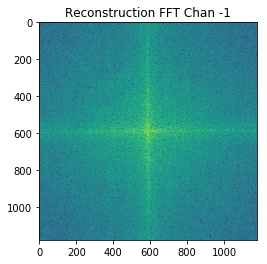

In [20]:
spectral_im[0,:,:] = spectral_im[0,:,:]/torch.amax(spectral_im[0,:,:])
#plt.imshow(spectral_im[0,:,:].detach().cpu().numpy())
f = torch.fft.fftshift(torch.fft.fft2(spectral_im[0,:,:].detach().cpu())).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Ground Truth')

In [ ]:
plt.imshow(obj_est[-1,:,:].detach().cpu().numpy())